# Notebook 5: The Full GPT Model — Assembly and Architecture

In the previous notebooks we built every piece of the transformer from scratch:

| Notebook | What We Built | Key Insight |
|----------|--------------|-------------|
| **01** | BPE Tokenizer | Text → integer tokens via learned merges |
| **02** | Bigram Baseline | Simplest possible language model (context-blind) |
| **03** | Self-Attention | Tokens learn to look at each other (Q, K, V) |
| **04** | Transformer Block | Attention + FFN + LayerNorm + Residuals |

Now we **assemble everything** into a complete GPT model — the same architecture behind GPT-2, GPT-3, and (conceptually) GPT-4. This notebook covers:

1. **GPTConfig** — A single dataclass to control the entire model
2. **Clean module implementations** — Production-quality attention, FFN, and blocks
3. **The GPT class** — Full model with weight tying and GPT-2-style initialization
4. **Weight initialization** — Why `normal(0, 0.02)` and scaled residual init matter
5. **Sanity checks** — Verify shapes, gradients, generation, and parameter sharing
6. **Architecture visualization** — See the full model structure

In [1]:
import os
import re
import json
import math
from dataclasses import dataclass
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

print(f"PyTorch version: {torch.__version__}")
print(f"Device: cpu (intentional for learning)")

PyTorch version: 2.10.0
Device: cpu (intentional for learning)


## 1. Setup: Tokenizer and Data

We reuse the BPE tokenizer from Notebook 1 and load our Shakespeare dataset.

In [2]:
# --- BPE Tokenizer (from Notebook 1, with fast pre-tokenized encode) ---

def _pre_tokenize(text):
    """Split text into chunks using GPT-2-style regex."""
    pattern = re.compile(r"'s|'t|'re|'ve|'m|'ll|'d| ?\w+| ?[^\s\w]+|\s+")
    chunks = pattern.findall(text)
    return [chunk.encode("utf-8") for chunk in chunks]

def merge_pair(token_ids, pair, new_id):
    merged = []
    i = 0
    while i < len(token_ids):
        if i < len(token_ids) - 1 and (token_ids[i], token_ids[i + 1]) == pair:
            merged.append(new_id)
            i += 2
        else:
            merged.append(token_ids[i])
            i += 1
    return merged

class BPETokenizer:
    def __init__(self, merges, vocab):
        self.merges = merges
        self.vocab = vocab
    @property
    def vocab_size(self):
        return len(self.vocab)
    def encode(self, text):
        chunks = _pre_tokenize(text)
        all_ids = []
        for chunk in chunks:
            word = list(chunk)
            for pair, new_id in self.merges:
                word = merge_pair(word, pair, new_id)
            all_ids.extend(word)
        return all_ids
    def decode(self, token_ids):
        return b"".join(self.vocab[id] for id in token_ids).decode("utf-8", errors="replace")
    @classmethod
    def load(cls, path):
        with open(path) as f:
            data = json.load(f)
        merges = [((a, b), new_id) for [a, b], new_id in data["merges"]]
        vocab = {int(k): bytes(v) for k, v in data["vocab"].items()}
        return cls(merges, vocab)

tokenizer = BPETokenizer.load(os.path.join("..", "data", "bpe_tokenizer.json"))

with open(os.path.join("..", "data", "tinyshakespeare.txt"), "r") as f:
    raw_text = f.read()

data = torch.tensor(tokenizer.encode(raw_text), dtype=torch.long)
print(f"Tokenizer: {tokenizer.vocab_size} tokens")
print(f"Dataset: {len(data):,} tokens ({len(raw_text):,} characters)")

Tokenizer: 512 tokens
Dataset: 568,603 tokens (1,115,394 characters)


## 2. GPTConfig — One Dataclass to Rule Them All

In Notebook 4, we had scattered variables: `d_model = 64`, `n_heads = 4`, `block_size = 64`...

For a real model, we need a **single source of truth** for all hyperparameters. Python's `@dataclass` is perfect for this — it gives us a clean, printable, immutable config object.

This is exactly how real GPT implementations work (see HuggingFace, nanoGPT, etc.).

In [3]:
@dataclass
class GPTConfig:
    """All hyperparameters for the GPT model in one place."""
    vocab_size: int = 512       # number of tokens in our BPE vocabulary
    block_size: int = 128       # maximum sequence length (context window)
    n_layers: int = 4           # number of transformer blocks (depth)
    n_heads: int = 4            # number of attention heads (parallel attention)
    d_model: int = 128          # embedding dimension (width)
    d_ff: int = 512             # feed-forward hidden dimension (typically 4x d_model)
    dropout: float = 0.1        # dropout rate for regularization

    def __post_init__(self):
        assert self.d_model % self.n_heads == 0, "d_model must be divisible by n_heads"

# Predefined configs at different scales
CONFIGS = {
    "tiny": GPTConfig(
        vocab_size=tokenizer.vocab_size,
        block_size=128, n_layers=4, n_heads=4, d_model=128, d_ff=512, dropout=0.1,
    ),
    "small": GPTConfig(
        vocab_size=tokenizer.vocab_size,
        block_size=256, n_layers=8, n_heads=8, d_model=256, d_ff=1024, dropout=0.1,
    ),
    "medium": GPTConfig(
        vocab_size=tokenizer.vocab_size,
        block_size=512, n_layers=12, n_heads=8, d_model=512, d_ff=2048, dropout=0.1,
    ),
}

print("Predefined configurations:")
print(f"{'Config':<10} {'d_model':>8} {'n_layers':>9} {'n_heads':>8} {'d_ff':>6} {'block_size':>11}")
print("-" * 55)
for name, cfg in CONFIGS.items():
    print(f"{name:<10} {cfg.d_model:>8} {cfg.n_layers:>9} {cfg.n_heads:>8} {cfg.d_ff:>6} {cfg.block_size:>11}")

print(f"\nFor comparison, real GPT-2 configs:")
print(f"  GPT-2 Small:  d_model=768,  12 layers, 12 heads, 117M params")
print(f"  GPT-2 Medium: d_model=1024, 24 layers, 16 heads, 345M params")
print(f"  GPT-2 Large:  d_model=1280, 36 layers, 20 heads, 774M params")
print(f"  GPT-2 XL:     d_model=1600, 48 layers, 25 heads, 1.5B params")

Predefined configurations:
Config      d_model  n_layers  n_heads   d_ff  block_size
-------------------------------------------------------
tiny            128         4        4    512         128
small           256         8        8   1024         256
medium          512        12        8   2048         512

For comparison, real GPT-2 configs:
  GPT-2 Small:  d_model=768,  12 layers, 12 heads, 117M params
  GPT-2 Medium: d_model=1024, 24 layers, 16 heads, 345M params
  GPT-2 Large:  d_model=1280, 36 layers, 20 heads, 774M params
  GPT-2 XL:     d_model=1600, 48 layers, 25 heads, 1.5B params


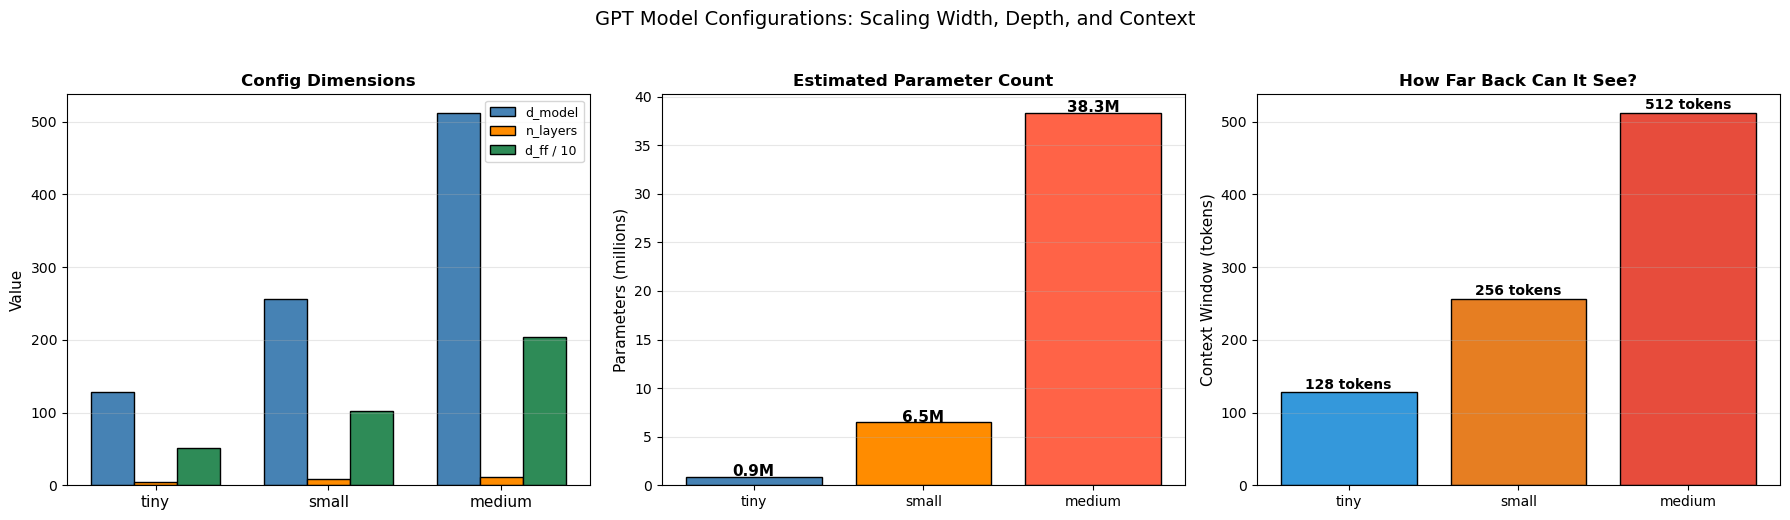

As models scale up:
  - More layers = deeper reasoning (more rounds of attend-then-process)
  - Wider d_model = richer representations (more information per token)
  - Larger context = longer memory (can reference more preceding text)
  - Parameters grow roughly quadratically with d_model


In [4]:
# Visualize the three configs as a scaling comparison

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Bar chart: key dimensions ---
ax = axes[0]
names = list(CONFIGS.keys())
d_models = [CONFIGS[n].d_model for n in names]
n_layers_list = [CONFIGS[n].n_layers for n in names]
d_ffs = [CONFIGS[n].d_ff for n in names]

x_pos = np.arange(len(names))
width = 0.25
ax.bar(x_pos - width, d_models, width, color='steelblue', label='d_model', edgecolor='black')
ax.bar(x_pos, n_layers_list, width, color='darkorange', label='n_layers', edgecolor='black')
ax.bar(x_pos + width, [n // 10 for n in d_ffs], width, color='seagreen', label='d_ff / 10', edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(names, fontsize=11)
ax.set_ylabel('Value', fontsize=11)
ax.set_title('Config Dimensions', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# --- Estimated parameter counts ---
ax = axes[1]
param_counts = []
for name in names:
    cfg = CONFIGS[name]
    m = GPT(cfg) if 'GPT' in dir() else None
    # Rough formula: embeddings + blocks + head
    emb_params = cfg.vocab_size * cfg.d_model + cfg.block_size * cfg.d_model
    block_params = cfg.n_layers * (
        4 * cfg.d_model * cfg.d_model +  # QKV + output projections
        2 * cfg.d_model * cfg.d_ff +     # FFN up + down
        cfg.d_ff + cfg.d_model +          # FFN biases
        4 * cfg.d_model                   # LayerNorm params
    )
    total = emb_params + block_params
    param_counts.append(total)

colors_bar = ['steelblue', 'darkorange', 'tomato']
bars = ax.bar(names, [p / 1e6 for p in param_counts], color=colors_bar, edgecolor='black')
for bar, p in zip(bars, param_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{p/1e6:.1f}M', ha='center', fontsize=11, fontweight='bold')
ax.set_ylabel('Parameters (millions)', fontsize=11)
ax.set_title('Estimated Parameter Count', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# --- Context window comparison ---
ax = axes[2]
block_sizes = [CONFIGS[n].block_size for n in names]
bars = ax.bar(names, block_sizes, color=['#3498db', '#e67e22', '#e74c3c'], edgecolor='black')
for bar, bs in zip(bars, block_sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{bs} tokens', ha='center', fontsize=10, fontweight='bold')
ax.set_ylabel('Context Window (tokens)', fontsize=11)
ax.set_title('How Far Back Can It See?', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('GPT Model Configurations: Scaling Width, Depth, and Context',
             fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

print("As models scale up:")
print("  - More layers = deeper reasoning (more rounds of attend-then-process)")
print("  - Wider d_model = richer representations (more information per token)")
print("  - Larger context = longer memory (can reference more preceding text)")
print("  - Parameters grow roughly quadratically with d_model")

## 3. Clean Module Implementations

These are the same components from Notebooks 3 and 4, but cleaned up for production use:

- **All hyperparameters come from `GPTConfig`** (no loose variables)
- **Dropout added** for regularization (randomly zeroes activations during training)
- **Type hints** for clarity

The architecture of each component is unchanged from what we studied.

In [5]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head causal self-attention.

    From Notebook 3: Q, K, V projections -> scaled dot-product -> causal mask -> output projection.
    New: fused QKV projection (single matrix instead of 3), dropout on attention and residual.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.n_heads = config.n_heads
        self.d_k = config.d_model // config.n_heads

        # Fused QKV: one big matrix multiply instead of three separate ones (faster)
        self.W_qkv = nn.Linear(config.d_model, 3 * config.d_model, bias=False)
        self.W_o = nn.Linear(config.d_model, config.d_model, bias=False)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.register_buffer(
            "mask",
            torch.tril(torch.ones(config.block_size, config.block_size))
        )

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.W_qkv(x)
        Q, K, V = qkv.chunk(3, dim=-1)

        Q = Q.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(B, T, self.n_heads, self.d_k).transpose(1, 2)

        attn = (Q @ K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn = attn.masked_fill(self.mask[:T, :T] == 0, float("-inf"))
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)

        out = (attn @ V).transpose(1, 2).contiguous().view(B, T, C)
        return self.resid_dropout(self.W_o(out))


class FeedForward(nn.Module):
    """
    Position-wise feed-forward network.

    From Notebook 4: Linear -> GELU -> Linear (expand then compress).
    New: dropout after the second linear layer.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.d_model, config.d_ff),
            nn.GELU(),
            nn.Linear(config.d_ff, config.d_model),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    """
    Pre-norm transformer block (from Notebook 4).

    x -> LayerNorm -> Attention -> + residual
      -> LayerNorm -> FFN       -> + residual
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.d_model)
        self.attn = MultiHeadAttention(config)
        self.ln2 = nn.LayerNorm(config.d_model)
        self.ffn = FeedForward(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))   # attend, then add back
        x = x + self.ffn(self.ln2(x))    # process, then add back
        return x

# Quick verification
test_cfg = GPTConfig(vocab_size=100, block_size=32, n_layers=2, n_heads=2, d_model=64, d_ff=256)
test_block = TransformerBlock(test_cfg)
test_x = torch.randn(1, 16, 64)
test_out = test_block(test_x)
print(f"TransformerBlock: {test_x.shape} -> {test_out.shape}")
print(f"Parameters per block: {sum(p.numel() for p in test_block.parameters()):,}")
print(f"  LayerNorm x2:  {sum(p.numel() for p in test_block.ln1.parameters()) + sum(p.numel() for p in test_block.ln2.parameters()):,}")
print(f"  Attention:      {sum(p.numel() for p in test_block.attn.parameters()):,}")
print(f"  FFN:            {sum(p.numel() for p in test_block.ffn.parameters()):,}")

TransformerBlock: torch.Size([1, 16, 64]) -> torch.Size([1, 16, 64])
Parameters per block: 49,728
  LayerNorm x2:  256
  Attention:      16,384
  FFN:            33,088


## 4. The Full GPT Model

Now we assemble everything into a single `GPT` class. Two key innovations we haven't seen yet:

### Weight Tying
The **token embedding** matrix and the **output projection** (lm_head) share the same weights. This means the model uses the same "understanding" of each token whether it is reading one or predicting one.

### GPT-2 Weight Initialization
Instead of PyTorch's default initialization, GPT-2 uses:
- `normal(0, 0.02)` for all weights
- **Scaled residual init**: output projections in attention and FFN get `normal(0, 0.02 / sqrt(2 * n_layers))`

The scaling prevents the residual stream from growing with depth.

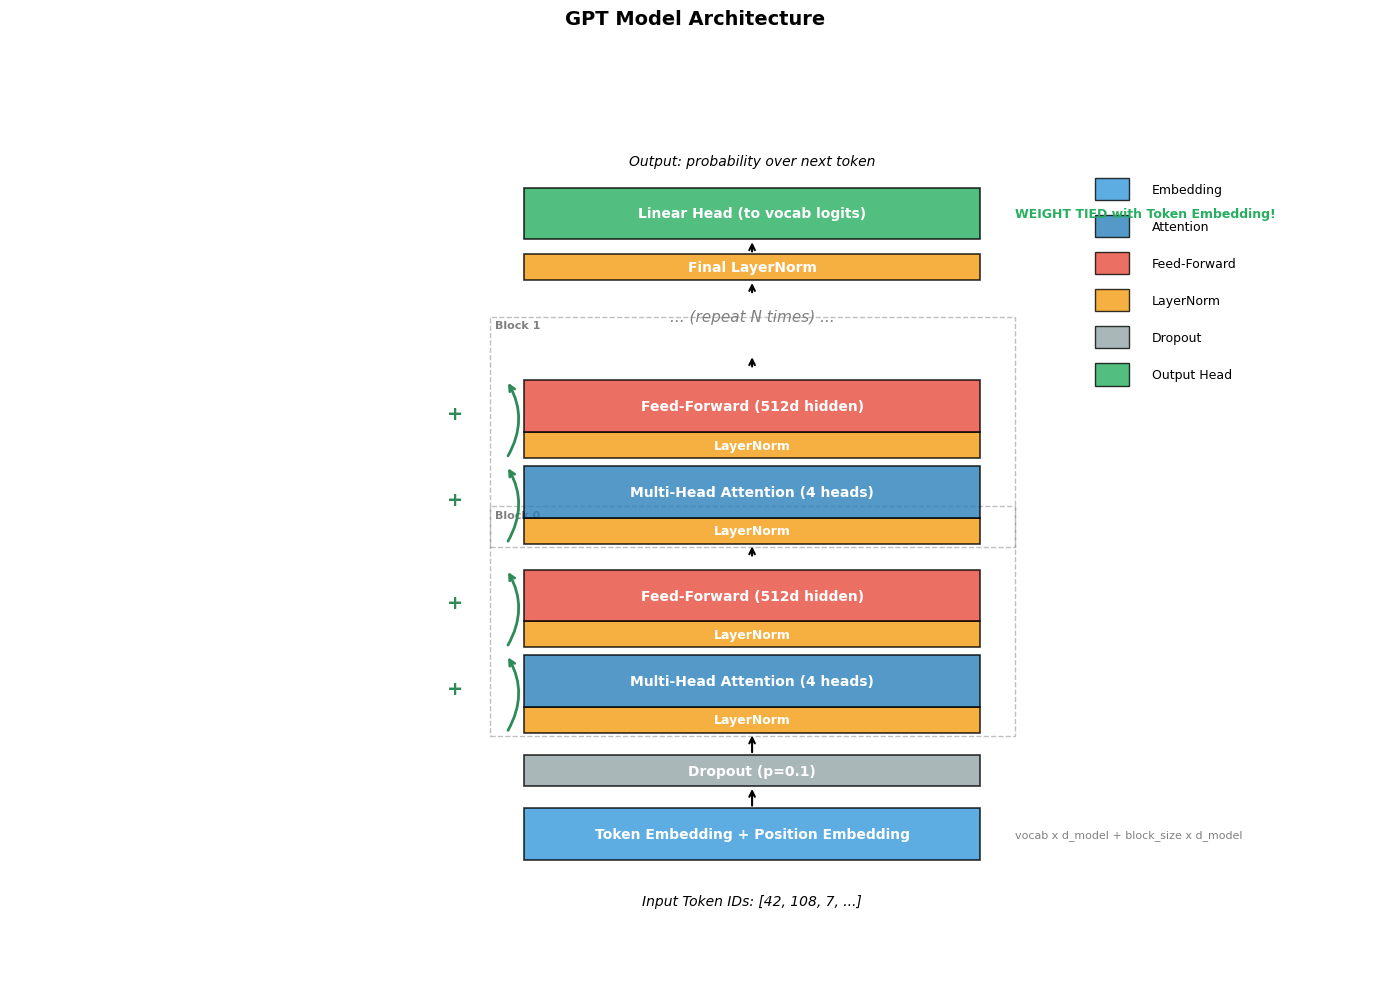

The full GPT model: Token IDs go in, next-token probabilities come out.
Everything between is just the components we already built, stacked and configured.


In [6]:
# Visualize the full GPT architecture

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(-1, 11)
ax.set_ylim(-0.5, 12)
ax.axis('off')

# Colors
c_emb = '#3498db'
c_attn = '#2980b9'
c_ffn = '#e74c3c'
c_norm = '#f39c12'
c_drop = '#95a5a6'
c_head = '#27ae60'

y = 0.5
box_w, box_h = 4, 0.7

def draw_box(ax, x, y, w, h, color, text, fontsize=10):
    rect = plt.Rectangle((x, y), w, h, facecolor=color, edgecolor='black',
                          linewidth=1.2, alpha=0.8, zorder=3)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center',
            fontsize=fontsize, fontweight='bold', color='white', zorder=4)

def draw_arrow(ax, x, y1, y2):
    ax.annotate('', xy=(x, y2), xytext=(x, y1),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

cx = 3.5  # center x

# Input
ax.text(cx + box_w/2, y, 'Input Token IDs: [42, 108, 7, ...]', ha='center', fontsize=10, style='italic')
y += 0.6

# Token + Position Embedding
draw_box(ax, cx, y, box_w, box_h, c_emb, 'Token Embedding + Position Embedding')
ax.text(cx + box_w + 0.3, y + box_h/2, f'vocab x d_model + block_size x d_model',
        fontsize=8, va='center', color='gray')
y += box_h
draw_arrow(ax, cx + box_w/2, y, y + 0.3)
y += 0.3

# Dropout
draw_box(ax, cx, y, box_w, box_h * 0.6, c_drop, 'Dropout (p=0.1)')
y += box_h * 0.6
draw_arrow(ax, cx + box_w/2, y, y + 0.3)
y += 0.3

# Transformer blocks
block_start_y = y
for layer in range(4):
    block_y = y

    # Block border
    block_rect = plt.Rectangle((cx - 0.3, y - 0.05), box_w + 0.6, box_h * 4 + 0.3,
                                facecolor='none', edgecolor='gray', linewidth=1,
                                linestyle='--', alpha=0.5)
    ax.add_patch(block_rect)
    ax.text(cx - 0.25, y + box_h * 4 + 0.1, f'Block {layer}',
            fontsize=8, color='gray', fontweight='bold')

    # LayerNorm 1
    draw_box(ax, cx, y, box_w, box_h * 0.5, c_norm, 'LayerNorm', fontsize=9)
    y += box_h * 0.5

    # Multi-Head Attention
    draw_box(ax, cx, y, box_w, box_h, c_attn, f'Multi-Head Attention ({4} heads)')

    # Residual arrow
    ax.annotate('', xy=(cx - 0.15, y + box_h), xytext=(cx - 0.15, block_y),
                arrowprops=dict(arrowstyle='->', color='seagreen', lw=2, connectionstyle='arc3,rad=0.3'))
    ax.text(cx - 0.6, block_y + (y + box_h - block_y)/2, '+', fontsize=14,
            color='seagreen', fontweight='bold', ha='center')
    y += box_h + 0.1

    mid_y = y
    # LayerNorm 2
    draw_box(ax, cx, y, box_w, box_h * 0.5, c_norm, 'LayerNorm', fontsize=9)
    y += box_h * 0.5

    # FFN
    draw_box(ax, cx, y, box_w, box_h, c_ffn, f'Feed-Forward ({512}d hidden)')

    # Residual arrow
    ax.annotate('', xy=(cx - 0.15, y + box_h), xytext=(cx - 0.15, mid_y),
                arrowprops=dict(arrowstyle='->', color='seagreen', lw=2, connectionstyle='arc3,rad=0.3'))
    ax.text(cx - 0.6, mid_y + (y + box_h - mid_y)/2, '+', fontsize=14,
            color='seagreen', fontweight='bold', ha='center')
    y += box_h + 0.15

    if layer < 3:
        draw_arrow(ax, cx + box_w/2, y, y + 0.2)
        y += 0.2

    # Only show first 2 and last block
    if layer == 1:
        y += 0.3
        ax.text(cx + box_w/2, y + 0.15, '... (repeat N times) ...',
                ha='center', fontsize=11, color='gray', style='italic')
        y += 0.5
        break

# Final LayerNorm
draw_arrow(ax, cx + box_w/2, y, y + 0.2)
y += 0.2
draw_box(ax, cx, y, box_w, box_h * 0.5, c_norm, 'Final LayerNorm')
y += box_h * 0.5
draw_arrow(ax, cx + box_w/2, y, y + 0.2)
y += 0.2

# Output head
draw_box(ax, cx, y, box_w, box_h, c_head, 'Linear Head (to vocab logits)')
ax.text(cx + box_w + 0.3, y + box_h/2, 'WEIGHT TIED with Token Embedding!',
        fontsize=9, va='center', color='#27ae60', fontweight='bold')
y += box_h + 0.3

# Output
ax.text(cx + box_w/2, y, 'Output: probability over next token', ha='center', fontsize=10, style='italic')

# Legend
legend_items = [
    (c_emb, 'Embedding'), (c_attn, 'Attention'), (c_ffn, 'Feed-Forward'),
    (c_norm, 'LayerNorm'), (c_drop, 'Dropout'), (c_head, 'Output Head'),
]
for i, (color, label) in enumerate(legend_items):
    ax.add_patch(plt.Rectangle((8.5, 10 - i * 0.5), 0.3, 0.3,
                                facecolor=color, edgecolor='black', alpha=0.8))
    ax.text(9, 10 - i * 0.5 + 0.15, label, fontsize=9, va='center')

plt.title('GPT Model Architecture', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("The full GPT model: Token IDs go in, next-token probabilities come out.")
print("Everything between is just the components we already built, stacked and configured.")

In [7]:
class GPT(nn.Module):
    """
    GPT Language Model.

    Architecture:
        Token Embedding + Positional Embedding
        -> Dropout
        -> N x TransformerBlock (pre-norm with residual connections)
        -> Final LayerNorm
        -> Linear projection to vocabulary (weight-tied with token embedding)
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        # Embeddings
        self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_emb = nn.Embedding(config.block_size, config.d_model)
        self.drop = nn.Dropout(config.dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList(
            [TransformerBlock(config) for _ in range(config.n_layers)]
        )

        # Final layer norm + output projection
        self.ln_f = nn.LayerNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # --- Weight Tying ---
        # Share weights between token embedding and output projection.
        # The embedding maps token_id -> vector. The output head maps vector -> token_id.
        # These are inverse operations, so sharing weights makes both better.
        self.token_emb.weight = self.lm_head.weight

        # --- Weight Initialization (GPT-2 style) ---
        self.apply(self._init_weights)
        # Scaled init for residual output projections
        for pn, p in self.named_parameters():
            if pn.endswith("W_o.weight") or pn.endswith("net.2.weight"):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layers))

    def _init_weights(self, module):
        """GPT-2 weight initialization: normal(0, 0.02) for everything."""
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.config.block_size, f"Sequence length {T} > block_size {self.config.block_size}"

        tok_emb = self.token_emb(idx)               # (B, T, d_model)
        pos_emb = self.pos_emb(torch.arange(T))     # (T, d_model)
        x = self.drop(tok_emb + pos_emb)            # (B, T, d_model)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)                            # (B, T, d_model)
        logits = self.lm_head(x)                    # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1)
            )

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """Autoregressive generation with temperature and top-k sampling."""
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float("-inf")

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx

    def count_parameters(self):
        """Count and display parameter breakdown."""
        total = sum(p.numel() for p in self.parameters())
        tied = self.token_emb.weight.numel()
        block_params = sum(p.numel() for p in self.blocks[0].parameters())

        print(f"Total parameters: {total:,}")
        print(f"  (of which {tied:,} are weight-tied between embedding and output)")
        print(f"\nBreakdown:")
        print(f"  Token embedding:     {self.token_emb.weight.numel():>10,}  (shared with lm_head)")
        print(f"  Position embedding:  {self.pos_emb.weight.numel():>10,}")
        print(f"  Per block:           {block_params:>10,}  x {self.config.n_layers} = {block_params * self.config.n_layers:,}")
        print(f"  Final LayerNorm:     {sum(p.numel() for p in self.ln_f.parameters()):>10,}")
        return total

# Instantiate the tiny config
config = CONFIGS["tiny"]
print(f"Building GPT with config: {config}\n")

torch.manual_seed(42)
model = GPT(config)
model.count_parameters()

Building GPT with config: GPTConfig(vocab_size=512, block_size=128, n_layers=4, n_heads=4, d_model=128, d_ff=512, dropout=0.1)

Total parameters: 873,216
  (of which 65,536 are weight-tied between embedding and output)

Breakdown:
  Token embedding:         65,536  (shared with lm_head)
  Position embedding:      16,384
  Per block:              197,760  x 4 = 791,040
  Final LayerNorm:            256


873216

### Visualizing Weight Initialization

Weight initialization is one of those things that sounds boring but can make or break training. Let us see what GPT-2's `normal(0, 0.02)` actually looks like, and why the **scaled residual init** matters.

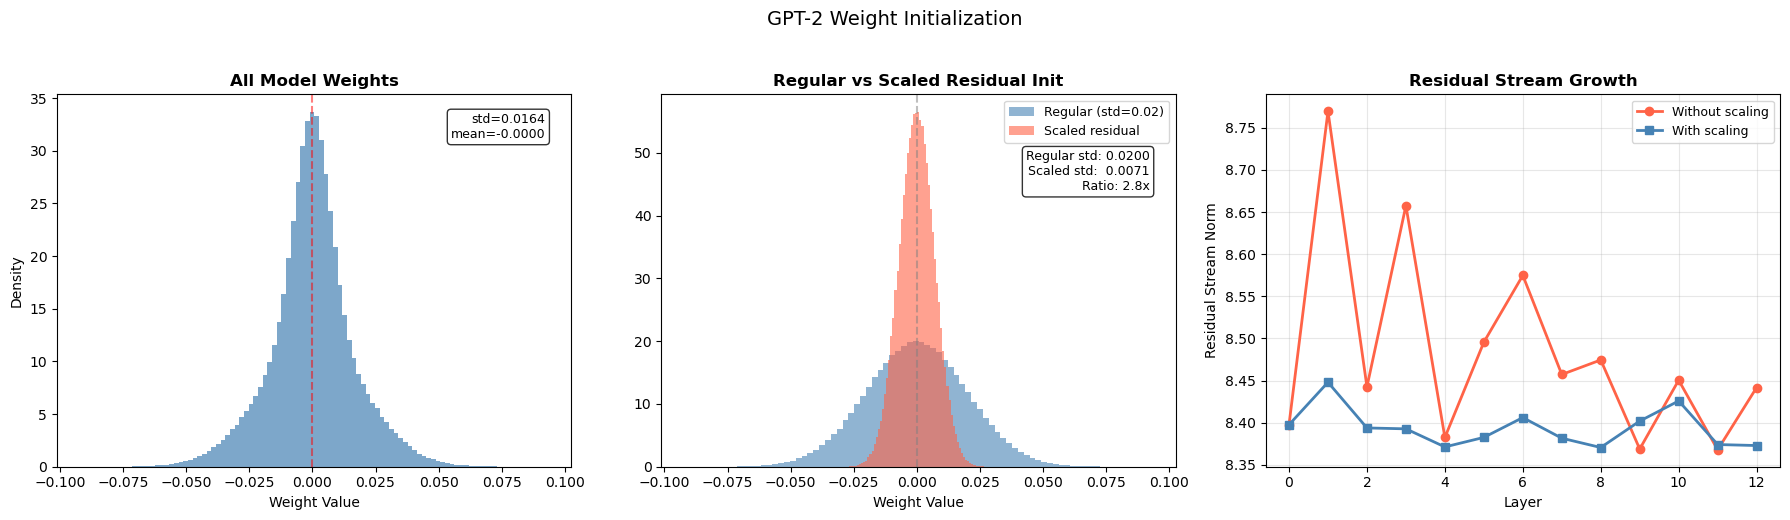

Left:   All weights follow normal(0, 0.02) -- tight around zero
Middle: Residual output projections (W_o, FFN output) have SMALLER std
        Scaled by 1/sqrt(2 * 4) = 0.354
Right:  Without scaling, the residual stream norm grows with depth.
        With scaling, it stays controlled. This prevents early training instability.


In [8]:
# Compare weight distributions: standard init vs GPT-2 init vs scaled residual init

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Collect weight distributions from the model
all_weights = []
residual_weights = []
other_weights = []

for name, param in model.named_parameters():
    if 'weight' in name and param.dim() >= 2:
        vals = param.detach().flatten().numpy()
        all_weights.extend(vals)
        if name.endswith("W_o.weight") or name.endswith("net.2.weight"):
            residual_weights.extend(vals)
        else:
            other_weights.extend(vals)

# --- Panel 1: All weights ---
ax = axes[0]
ax.hist(all_weights, bins=100, color='steelblue', alpha=0.7, density=True, edgecolor='none')
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax.set_title('All Model Weights', fontsize=12, fontweight='bold')
ax.set_xlabel('Weight Value', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.text(0.95, 0.95, f'std={np.std(all_weights):.4f}\nmean={np.mean(all_weights):.4f}',
        transform=ax.transAxes, ha='right', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# --- Panel 2: Regular vs Scaled ---
ax = axes[1]
ax.hist(other_weights, bins=80, color='steelblue', alpha=0.6, density=True,
        edgecolor='none', label=f'Regular (std=0.02)')
ax.hist(residual_weights, bins=80, color='tomato', alpha=0.6, density=True,
        edgecolor='none', label=f'Scaled residual')
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Regular vs Scaled Residual Init', fontsize=12, fontweight='bold')
ax.set_xlabel('Weight Value', fontsize=10)
ax.legend(fontsize=9)
ax.text(0.95, 0.85, f'Regular std: {np.std(other_weights):.4f}\n'
        f'Scaled std:  {np.std(residual_weights):.4f}\n'
        f'Ratio: {np.std(other_weights)/np.std(residual_weights):.1f}x',
        transform=ax.transAxes, ha='right', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# --- Panel 3: Why scaling matters ---
ax = axes[2]
# Simulate residual stream growth with and without scaling
n_layers_sim = 12
torch.manual_seed(42)
x_sim = torch.randn(1, 64)

# Without scaling: each residual adds normal(0, 0.02) output
norms_unscaled = [x_sim.norm().item()]
norms_scaled = [x_sim.norm().item()]

for layer in range(n_layers_sim):
    # Unscaled: residual output has std 0.02 * sqrt(d) ~ 0.16
    x_unscaled = x_sim + torch.randn(1, 64) * 0.02 * math.sqrt(64)
    norms_unscaled.append(x_unscaled.norm().item())

    # Scaled: residual output has std 0.02/sqrt(2*n_layers) * sqrt(d)
    scale = 0.02 / math.sqrt(2 * n_layers_sim)
    x_scaled = x_sim + torch.randn(1, 64) * scale * math.sqrt(64)
    norms_scaled.append(x_scaled.norm().item())

ax.plot(range(n_layers_sim + 1), norms_unscaled, 'o-', color='tomato', linewidth=2, label='Without scaling')
ax.plot(range(n_layers_sim + 1), norms_scaled, 's-', color='steelblue', linewidth=2, label='With scaling')
ax.set_xlabel('Layer', fontsize=10)
ax.set_ylabel('Residual Stream Norm', fontsize=10)
ax.set_title('Residual Stream Growth', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.suptitle('GPT-2 Weight Initialization', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

print("Left:   All weights follow normal(0, 0.02) -- tight around zero")
print("Middle: Residual output projections (W_o, FFN output) have SMALLER std")
print(f"        Scaled by 1/sqrt(2 * {config.n_layers}) = {1/math.sqrt(2*config.n_layers):.3f}")
print("Right:  Without scaling, the residual stream norm grows with depth.")
print("        With scaling, it stays controlled. This prevents early training instability.")

### Weight Tying: Why Embedding = Output Head

This is a surprisingly powerful trick. The **token embedding** matrix maps `token_id -> vector`. The **output head** maps `vector -> token_id` (logits). Since these are inverse operations, sharing the same weight matrix:

1. **Saves parameters** (one fewer copy of `vocab_size x d_model`)
2. **Improves performance** (the model learns a single, consistent representation per token)
3. **Makes semantic sense** (a token's "meaning" should be the same for reading and predicting)

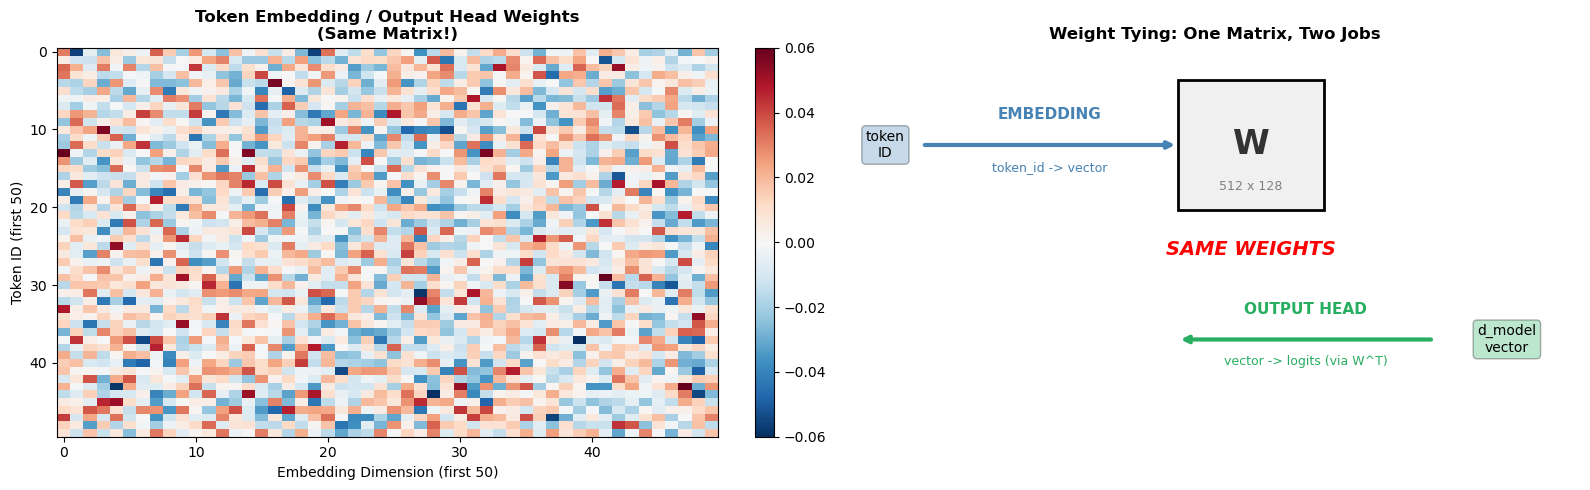

token_emb.weight is lm_head.weight: True
token_emb data_ptr: 5637931008
lm_head data_ptr:   5637931008
Same pointer = truly shared (not just same values)

Parameters saved: 65,536 (512 x 128)


In [9]:
# Verify weight tying and visualize what it means

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Panel 1: Show the shared matrix ---
ax = axes[0]
emb_w = model.token_emb.weight.detach()[:50, :50].numpy()  # first 50x50
im = ax.imshow(emb_w, cmap='RdBu_r', aspect='auto', vmin=-0.06, vmax=0.06)
ax.set_xlabel('Embedding Dimension (first 50)', fontsize=10)
ax.set_ylabel('Token ID (first 50)', fontsize=10)
ax.set_title('Token Embedding / Output Head Weights\n(Same Matrix!)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, fraction=0.046)

# --- Panel 2: Conceptual diagram ---
ax = axes[1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')

# Embedding direction (left to right)
ax.annotate('', xy=(4.5, 4.5), xytext=(1, 4.5),
            arrowprops=dict(arrowstyle='->', color='steelblue', lw=3))
ax.text(2.75, 4.9, 'EMBEDDING', ha='center', fontsize=11, color='steelblue', fontweight='bold')
ax.text(2.75, 4.1, 'token_id -> vector', ha='center', fontsize=9, color='steelblue')

# Shared matrix in the middle
rect = plt.Rectangle((4.5, 3.5), 2, 2, facecolor='#f0f0f0', edgecolor='black', linewidth=2)
ax.add_patch(rect)
ax.text(5.5, 4.5, 'W', ha='center', va='center', fontsize=24, fontweight='bold', color='#333')
ax.text(5.5, 3.8, f'{config.vocab_size} x {config.d_model}', ha='center', fontsize=9, color='gray')

# Output direction (right to left, below)
ax.annotate('', xy=(4.5, 1.5), xytext=(8, 1.5),
            arrowprops=dict(arrowstyle='->', color='#27ae60', lw=3))
ax.text(6.25, 1.9, 'OUTPUT HEAD', ha='center', fontsize=11, color='#27ae60', fontweight='bold')
ax.text(6.25, 1.1, 'vector -> logits (via W^T)', ha='center', fontsize=9, color='#27ae60')

# "SAME WEIGHTS" label
ax.text(5.5, 2.8, 'SAME WEIGHTS', ha='center', fontsize=14, fontweight='bold',
        color='red', style='italic')

# Token and vector labels
ax.text(0.5, 4.5, 'token\nID', ha='center', va='center', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='steelblue', alpha=0.3))
ax.text(9, 1.5, 'd_model\nvector', ha='center', va='center', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='#27ae60', alpha=0.3))

ax.set_title('Weight Tying: One Matrix, Two Jobs', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Prove they share memory
print(f"token_emb.weight is lm_head.weight: {model.token_emb.weight is model.lm_head.weight}")
print(f"token_emb data_ptr: {model.token_emb.weight.data_ptr()}")
print(f"lm_head data_ptr:   {model.lm_head.weight.data_ptr()}")
print(f"Same pointer = truly shared (not just same values)")
print(f"\nParameters saved: {config.vocab_size * config.d_model:,} ({config.vocab_size} x {config.d_model})")

## 5. Sanity Checks

Before training, we verify that the model works correctly. These checks catch bugs early.

In [10]:
# Check 1: Forward pass shapes and initial loss
print("=" * 50)
print("CHECK 1: Forward Pass")
print("=" * 50)

x_test = torch.randint(0, config.vocab_size, (2, 32))  # batch=2, seq_len=32
y_test = torch.randint(0, config.vocab_size, (2, 32))

logits, loss = model(x_test, y_test)
expected_loss = math.log(config.vocab_size)

print(f"Input shape:  {x_test.shape}")
print(f"Logits shape: {logits.shape}  (expected: [2, 32, {config.vocab_size}])")
print(f"Loss: {loss.item():.4f}")
print(f"Expected (random): {expected_loss:.4f}  (= ln({config.vocab_size}))")
print(f"Match: {'PASS' if abs(loss.item() - expected_loss) < 0.5 else 'FAIL'}")

CHECK 1: Forward Pass
Input shape:  torch.Size([2, 32])
Logits shape: torch.Size([2, 32, 512])  (expected: [2, 32, 512])
Loss: 6.2451
Expected (random): 6.2383  (= ln(512))
Match: PASS


In [11]:
# Check 2: Gradient flow
print("=" * 50)
print("CHECK 2: Gradient Flow")
print("=" * 50)

model.zero_grad()
_, loss = model(x_test, y_test)
loss.backward()

no_grad = []
has_grad = []
for name, param in model.named_parameters():
    if param.grad is None or param.grad.abs().sum() == 0:
        no_grad.append(name)
    else:
        has_grad.append(name)

print(f"Parameters with gradients: {len(has_grad)}/{len(has_grad) + len(no_grad)}")
if no_grad:
    print(f"WARNING - no gradients: {no_grad}")
else:
    print("All parameters receiving gradients. PASS")

CHECK 2: Gradient Flow
Parameters with gradients: 44/44
All parameters receiving gradients. PASS


In [12]:
# Check 3: Generation
print("=" * 50)
print("CHECK 3: Generation")
print("=" * 50)

start = torch.zeros((1, 1), dtype=torch.long)
generated = model.generate(start, max_new_tokens=50, temperature=1.0, top_k=10)
print(f"Generated {generated.shape[1]} tokens")
print(f"Text (untrained): {tokenizer.decode(generated[0].tolist())}")
print("\n(Gibberish is expected -- the model is not trained yet!)")
print("PASS" if generated.shape[1] == 51 else "FAIL")

CHECK 3: Generation
Generated 51 tokens
Text (untrained):   ES   g'sillill���ath canKING��%� lo lo loother�J���;Jct�est E u no toeeghtAnd��C

(Gibberish is expected -- the model is not trained yet!)
PASS


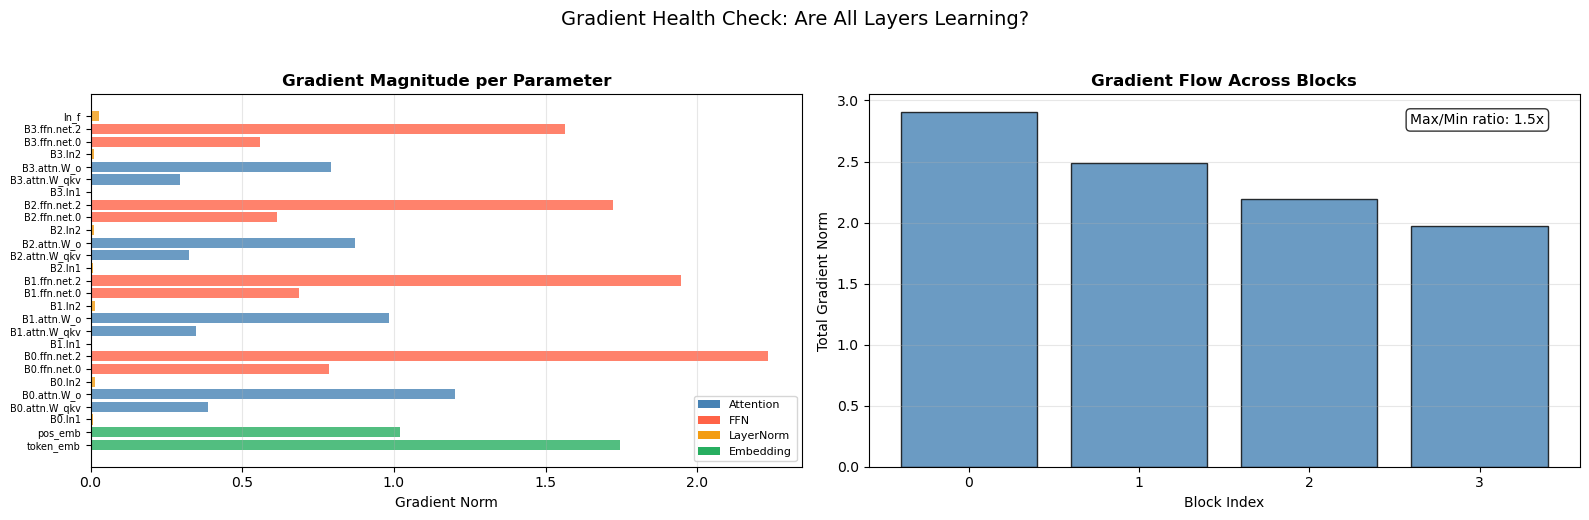

Gradient norm ratio (max/min across blocks): 1.5x
Healthy -- gradients are relatively uniform across all blocks.
This means residual connections + scaled init are working correctly.


In [13]:
# Visualize gradient magnitudes through the model

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Panel 1: Gradient magnitude per layer ---
ax = axes[0]
layer_names = []
grad_norms = []

for name, param in model.named_parameters():
    if param.grad is not None and 'weight' in name:
        layer_names.append(name.replace('blocks.', 'B').replace('.weight', ''))
        grad_norms.append(param.grad.norm().item())

# Color by type
colors = []
for name in layer_names:
    if 'attn' in name or 'qkv' in name or 'W_o' in name:
        colors.append('steelblue')
    elif 'ffn' in name or 'net' in name:
        colors.append('tomato')
    elif 'ln' in name:
        colors.append('#f39c12')
    elif 'emb' in name:
        colors.append('#27ae60')
    else:
        colors.append('gray')

ax.barh(range(len(layer_names)), grad_norms, color=colors, edgecolor='none', alpha=0.8)
ax.set_yticks(range(len(layer_names)))
ax.set_yticklabels(layer_names, fontsize=7)
ax.set_xlabel('Gradient Norm', fontsize=10)
ax.set_title('Gradient Magnitude per Parameter', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Attention'),
    Patch(facecolor='tomato', label='FFN'),
    Patch(facecolor='#f39c12', label='LayerNorm'),
    Patch(facecolor='#27ae60', label='Embedding'),
]
ax.legend(handles=legend_elements, fontsize=8, loc='lower right')

# --- Panel 2: Gradient norm by block ---
ax = axes[1]
block_grad_norms = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        # Extract block number
        parts = name.split('.')
        if 'blocks' in parts:
            block_idx = int(parts[parts.index('blocks') + 1])
            if block_idx not in block_grad_norms:
                block_grad_norms[block_idx] = 0
            block_grad_norms[block_idx] += param.grad.norm().item() ** 2

block_indices = sorted(block_grad_norms.keys())
block_norms = [math.sqrt(block_grad_norms[i]) for i in block_indices]

ax.bar(block_indices, block_norms, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_xlabel('Block Index', fontsize=10)
ax.set_ylabel('Total Gradient Norm', fontsize=10)
ax.set_title('Gradient Flow Across Blocks', fontsize=12, fontweight='bold')
ax.set_xticks(block_indices)
ax.grid(True, alpha=0.3, axis='y')

# Check if gradients are relatively uniform (good) or vanishing (bad)
ratio = max(block_norms) / min(block_norms) if min(block_norms) > 0 else float('inf')
ax.text(0.95, 0.95, f'Max/Min ratio: {ratio:.1f}x',
        transform=ax.transAxes, ha='right', va='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Gradient Health Check: Are All Layers Learning?', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

print(f"Gradient norm ratio (max/min across blocks): {ratio:.1f}x")
if ratio < 10:
    print("Healthy -- gradients are relatively uniform across all blocks.")
    print("This means residual connections + scaled init are working correctly.")
else:
    print("Warning -- gradients vary a lot. Deeper blocks may train slower.")

## 6. Parameter Count Comparison

Let us see how our three configs compare, and understand where parameters actually live in the model.

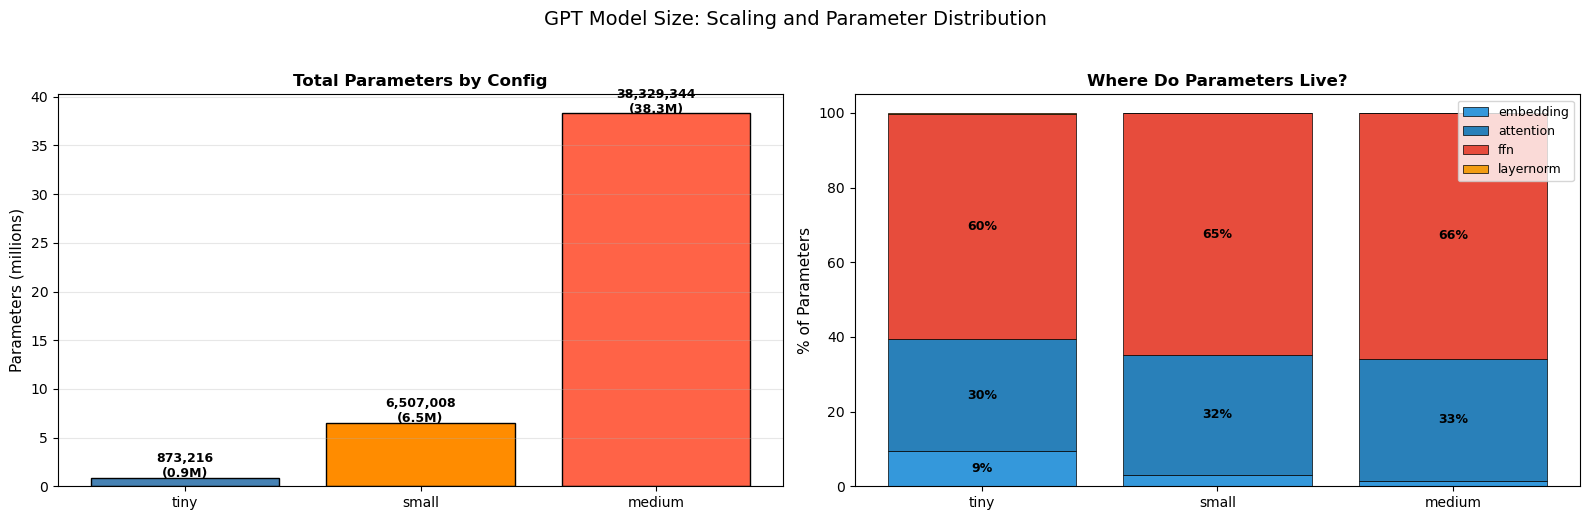

Key observations:
  - FFN dominates: ~60-65% of parameters are in feed-forward layers
  - Attention is relatively cheap: ~25-30% of parameters
  - Embeddings matter less at scale (fixed vocab_size x d_model)
  - LayerNorm adds negligible parameters but is essential for training

Config            Total    Embedding    Attention          FFN  LayerNorm
----------------------------------------------------------------------
tiny            873,216       81,920      262,144      526,848      2,304
small         6,507,008      196,608    2,097,152    4,204,544      8,704
medium       38,329,344      524,288   12,582,912   25,196,544     25,600


In [14]:
# Detailed parameter breakdown for all configs

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Build data
config_data = {}
for name, cfg in CONFIGS.items():
    m = GPT(cfg)

    emb_params = cfg.vocab_size * cfg.d_model + cfg.block_size * cfg.d_model
    attn_per_block = sum(p.numel() for p in m.blocks[0].attn.parameters())
    ffn_per_block = sum(p.numel() for p in m.blocks[0].ffn.parameters())
    ln_per_block = sum(p.numel() for p in m.blocks[0].ln1.parameters()) + sum(p.numel() for p in m.blocks[0].ln2.parameters())
    total_blocks = (attn_per_block + ffn_per_block + ln_per_block) * cfg.n_layers
    ln_final = sum(p.numel() for p in m.ln_f.parameters())
    total = sum(p.numel() for p in m.parameters())

    config_data[name] = {
        'total': total,
        'embedding': emb_params,
        'attention': attn_per_block * cfg.n_layers,
        'ffn': ffn_per_block * cfg.n_layers,
        'layernorm': (ln_per_block * cfg.n_layers) + ln_final,
    }
    del m

# --- Panel 1: Total parameter bars ---
ax = axes[0]
names = list(config_data.keys())
totals = [config_data[n]['total'] for n in names]
colors_bar = ['steelblue', 'darkorange', 'tomato']

bars = ax.bar(names, [t / 1e6 for t in totals], color=colors_bar, edgecolor='black')
for bar, t in zip(bars, totals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{t:,.0f}\n({t/1e6:.1f}M)', ha='center', fontsize=9, fontweight='bold')
ax.set_ylabel('Parameters (millions)', fontsize=11)
ax.set_title('Total Parameters by Config', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# --- Panel 2: Stacked breakdown ---
ax = axes[1]
components = ['embedding', 'attention', 'ffn', 'layernorm']
comp_colors = ['#3498db', '#2980b9', '#e74c3c', '#f39c12']
bottom = np.zeros(len(names))

for comp, color in zip(components, comp_colors):
    vals = [config_data[n][comp] / config_data[n]['total'] * 100 for n in names]
    ax.bar(names, vals, bottom=bottom, color=color, edgecolor='black', linewidth=0.5, label=comp)
    # Label if > 10%
    for i, v in enumerate(vals):
        if v > 8:
            ax.text(i, bottom[i] + v/2, f'{v:.0f}%', ha='center', va='center', fontsize=9, fontweight='bold')
    bottom += vals

ax.set_ylabel('% of Parameters', fontsize=11)
ax.set_title('Where Do Parameters Live?', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
ax.set_ylim(0, 105)

plt.suptitle('GPT Model Size: Scaling and Parameter Distribution', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

print("Key observations:")
print("  - FFN dominates: ~60-65% of parameters are in feed-forward layers")
print("  - Attention is relatively cheap: ~25-30% of parameters")
print("  - Embeddings matter less at scale (fixed vocab_size x d_model)")
print("  - LayerNorm adds negligible parameters but is essential for training")

# Print exact counts
print(f"\n{'Config':<10} {'Total':>12} {'Embedding':>12} {'Attention':>12} {'FFN':>12} {'LayerNorm':>10}")
print("-" * 70)
for name in names:
    d = config_data[name]
    print(f"{name:<10} {d['total']:>12,} {d['embedding']:>12,} {d['attention']:>12,} {d['ffn']:>12,} {d['layernorm']:>10,}")

## 7. Generation: Temperature and Top-k Sampling

Our GPT model's `generate()` method has two controls:
- **Temperature**: scales logits before softmax. High = more random, low = more deterministic.
- **Top-k**: only consider the k most likely tokens (ignore the rest).

These don't change the model — they change how we **sample** from its predictions.

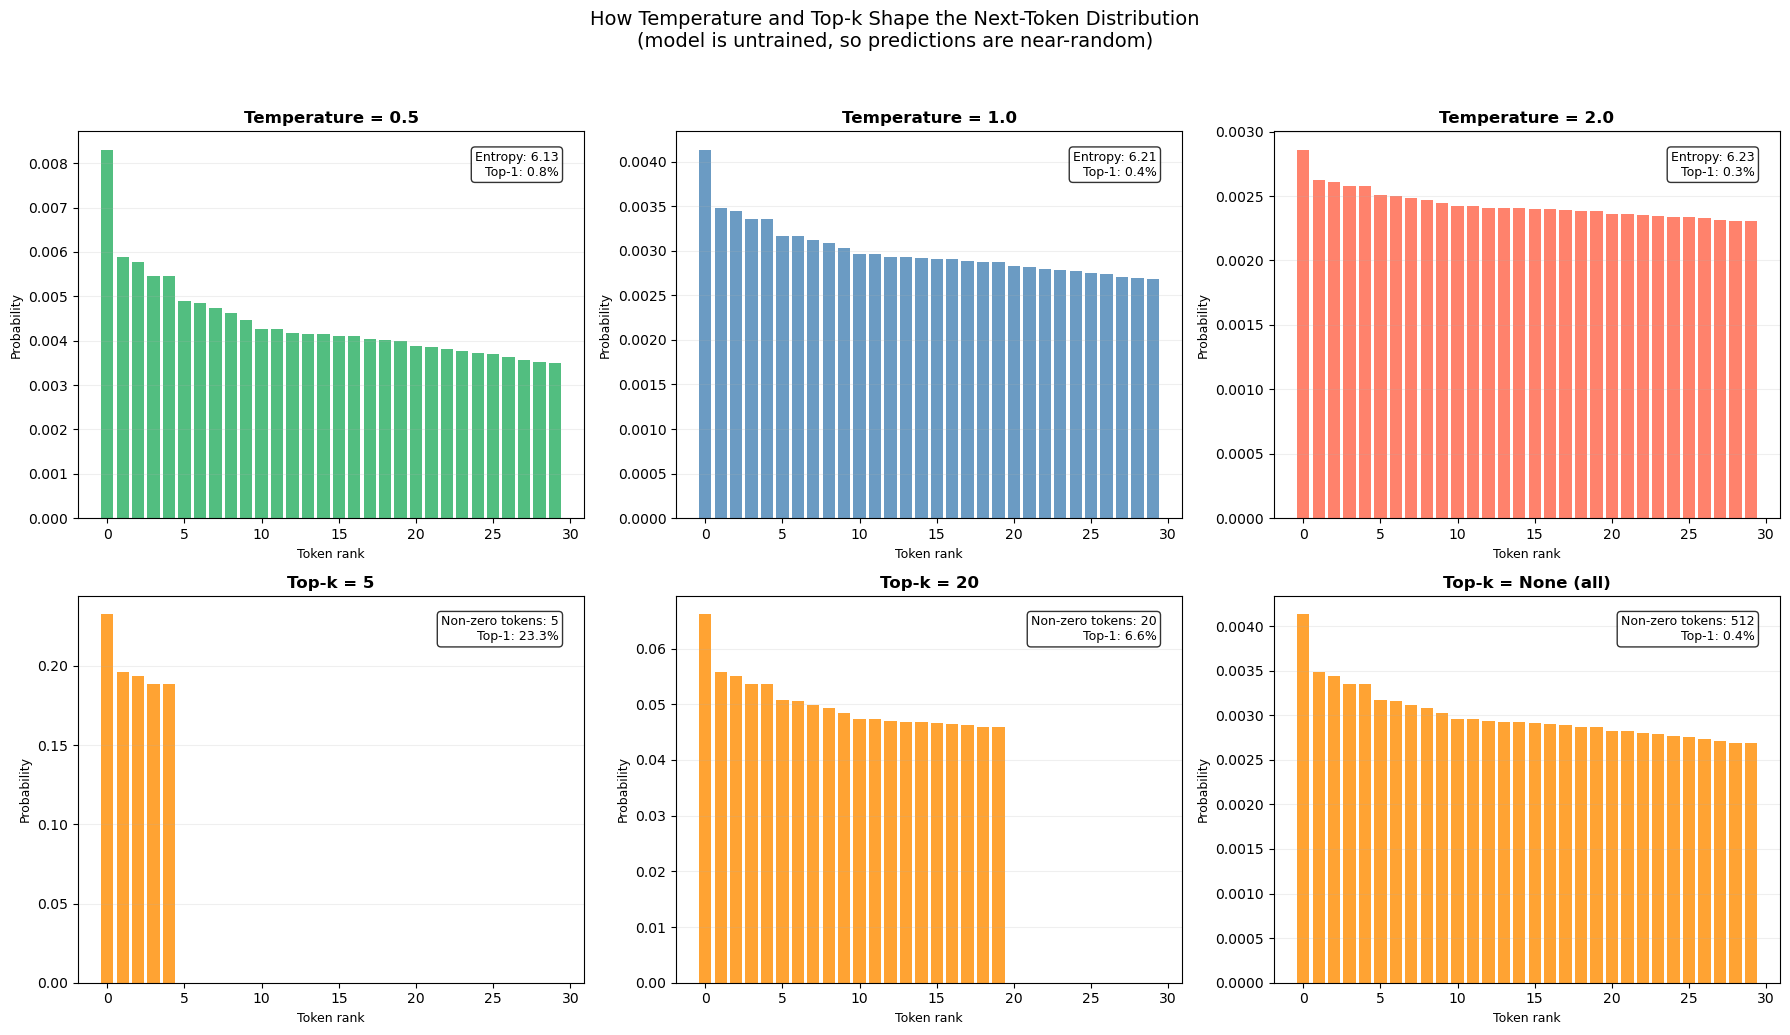

Temperature controls SHARPNESS:
  T=0.5: peaked distribution (conservative, repetitive text)
  T=1.0: as-trained distribution (balanced)
  T=2.0: flat distribution (creative but often incoherent)

Top-k controls BREADTH:
  k=5:  only pick from top 5 tokens (very constrained)
  k=20: pick from top 20 (moderate diversity)
  k=None: all tokens are fair game (maximum diversity)


In [15]:
# Visualize how temperature and top-k affect the probability distribution

# Get a real prediction from the model
sample_text = "ROMEO:\nBut soft"
sample_ids = tokenizer.encode(sample_text)[:config.block_size]
sample_input = torch.tensor([sample_ids])

model.eval()
with torch.no_grad():
    logits, _ = model(sample_input)
    raw_logits = logits[0, -1, :]  # logits for next token prediction
model.train()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- Row 1: Temperature effect ---
temperatures = [0.5, 1.0, 2.0]
for col, temp in enumerate(temperatures):
    ax = axes[0, col]
    scaled = raw_logits / temp
    probs = F.softmax(scaled, dim=-1).numpy()

    # Sort by probability
    sorted_idx = np.argsort(probs)[::-1]
    top_n = 30
    top_probs = probs[sorted_idx[:top_n]]
    top_tokens = [tokenizer.vocab[int(i)].decode('utf-8', errors='replace').strip()[:8] for i in sorted_idx[:top_n]]

    color = 'steelblue' if temp == 1.0 else ('tomato' if temp > 1 else '#27ae60')
    ax.bar(range(top_n), top_probs, color=color, edgecolor='none', alpha=0.8)
    ax.set_title(f'Temperature = {temp}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Token rank', fontsize=9)
    ax.set_ylabel('Probability', fontsize=9)

    entropy = -np.sum(probs * np.log(probs + 1e-10))
    ax.text(0.95, 0.95, f'Entropy: {entropy:.2f}\nTop-1: {top_probs[0]:.1%}',
            transform=ax.transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True, alpha=0.2, axis='y')

# --- Row 2: Top-k effect ---
top_ks = [5, 20, None]
for col, k in enumerate(top_ks):
    ax = axes[1, col]
    scaled = raw_logits / 1.0  # temperature = 1

    if k is not None:
        v, _ = torch.topk(scaled, k)
        scaled[scaled < v[-1]] = float("-inf")

    probs = F.softmax(scaled, dim=-1).numpy()

    sorted_idx = np.argsort(probs)[::-1]
    top_n = 30
    top_probs = probs[sorted_idx[:top_n]]

    nonzero = np.sum(probs > 1e-6)
    color = 'darkorange'
    ax.bar(range(top_n), top_probs, color=color, edgecolor='none', alpha=0.8)

    k_label = str(k) if k else 'None (all)'
    ax.set_title(f'Top-k = {k_label}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Token rank', fontsize=9)
    ax.set_ylabel('Probability', fontsize=9)

    ax.text(0.95, 0.95, f'Non-zero tokens: {nonzero}\nTop-1: {top_probs[0]:.1%}',
            transform=ax.transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True, alpha=0.2, axis='y')

plt.suptitle('How Temperature and Top-k Shape the Next-Token Distribution\n'
             '(model is untrained, so predictions are near-random)',
             fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

print("Temperature controls SHARPNESS:")
print("  T=0.5: peaked distribution (conservative, repetitive text)")
print("  T=1.0: as-trained distribution (balanced)")
print("  T=2.0: flat distribution (creative but often incoherent)")
print("\nTop-k controls BREADTH:")
print("  k=5:  only pick from top 5 tokens (very constrained)")
print("  k=20: pick from top 20 (moderate diversity)")
print("  k=None: all tokens are fair game (maximum diversity)")

## 8. Save Model Configuration

We save the model configs and parameter counts for comparison in Notebook 6.

In [16]:
# Save all config parameter counts for Notebook 6

config_params = {}
for name, cfg in CONFIGS.items():
    m = GPT(cfg)
    config_params[name] = {
        "total_params": sum(p.numel() for p in m.parameters()),
        "d_model": cfg.d_model,
        "n_layers": cfg.n_layers,
        "n_heads": cfg.n_heads,
        "d_ff": cfg.d_ff,
        "block_size": cfg.block_size,
    }
    del m

print("Configs saved for Notebook 6:")
for name, info in config_params.items():
    print(f"  {name}: {info['total_params']:,} parameters")

print("\nThe model is built and verified. Next notebook: TRAINING.")

Configs saved for Notebook 6:
  tiny: 873,216 parameters
  small: 6,507,008 parameters
  medium: 38,329,344 parameters

The model is built and verified. Next notebook: TRAINING.


## Summary

We assembled a **complete GPT language model** from the components built in Notebooks 1-4:

| Component | From | Role |
|-----------|------|------|
| BPE Tokenizer | NB 01 | Text to token IDs |
| Multi-Head Attention | NB 03 | Tokens attend to each other |
| Feed-Forward Network | NB 04 | Nonlinear processing per token |
| LayerNorm + Residuals | NB 04 | Training stability |
| **GPT (this notebook)** | NB 05 | **Full assembly with config, init, generation** |

### Key Design Decisions
1. **Pre-norm architecture**: LayerNorm before (not after) attention/FFN -- better gradient flow
2. **Weight tying**: Embedding and output head share weights -- fewer params, better quality
3. **Scaled residual init**: Output projections initialized smaller to prevent signal explosion
4. **Dataclass config**: Single source of truth for all hyperparameters

### What is Next
**Notebook 6** will train this model on Shakespeare with:
- Learning rate warmup + cosine decay
- Training curves and loss tracking
- Text generation at different scales
- Final ablation: comparing everything we have built